CAR FAC - Cascade of Asymmetric Resonators with Fast Acting Compression
===

The code below implements a model of the cochlea developed by Dick Lyon.

It is described in detail in his [book](http://www.machinehearing.org). Page numbers in the code comments refer to the pages of this book.


Following on from the previous notebook on [the CARFAC model](http://nbviewer.ipython.org/github/vschaik/CARFAC/blob/master/CARFAC.ipynb) which added the Outer Hair Cell to the Basilar Membrane model, we now incorporate the feedback loop that controls the gain of the OHCs. To do so, we implement the following structure:

<img src="./images/AGC1.png" alt="AGC blocks" style="width: 600px;">

Each temporal filter output is also spatially filtered as shown here:

<img src="./images/AGC2.png" alt="AGC spatial filter" style="width: 600px;">


To measure the linearised transfer functions of the adapted cochlea, we first play a 700 Hz pure tone stimulus through the cochlea, after which we fix the value of b for each section, and then run the log sine sweep signal through the cochlea as before to measure the transfer function.


In [1]:
%matplotlib notebook
from pylab import *
from scipy import signal
import colorsys
from mpl_toolkits.mplot3d import Axes3D

fs = 32000.0                  # sample frequency
dur = 1.0                     # stimulus length
npoints = int(fs*dur)

nsec = 100                    # number of sections in the cochlea between
xlow = 0.10                   # lowest frequency position along the cochlea and
xhigh = 0.90                  # highest frequency position along the cochlea

# create input tone
f0 = 700                      # tone frequency
t1 = arange(npoints)/fs       # sample times
gain = 0.1                    # input gain
stimulus = gain*sin(2*pi*f0*t1)

# BM parameters
x = linspace(xhigh,xlow,nsec) # position along the cochlea 1 = base, 0 = apex
f = 165.4*(10**(2.1*x)-1)     # Greenwood for humans
a0 = cos(2*pi*f/fs)           # a0 and c0 control the poles and zeros
c0 = sin(2*pi*f/fs)

damping = 0.2                 # damping factor
r = 1 - damping*2*pi*f/fs     # pole & zero radius actual
r1 = 1 - damping*2*pi*f/fs    # pole & zero radius minimum (set point)
h = c0                        # p302 h=c0 puts the zeros 1/2 octave above poles
g = (1-2*a0*r+r*r)/(1-(2*a0-h*c0)*r+r*r)  # p303 this gives 0dB DC gain for BM

f_hpf = 20                    # p328 20Hz corner for the BM HPF
q = 1/(1+(2*pi*f_hpf/fs))     # corresponding IIR coefficient 

tau_in = 10e-3                # p329 transmitter creation time constant
c_in = 1/(fs*tau_in)          # p329 corresponding IIR coefficient    
tau_out = 0.5e-3              # p329 transmitter depletion time constant
c_out = 1/(fs*tau_out)        # p329 corresponding IIR coefficient 
tau_IHC = 80e-6               # p329 ~8kHz LPF for IHC output
c_IHC = 1/(fs*tau_IHC)        # corresponding IIR coefficient 

# OHC parameters
scale = 0.1                   # p313 NLF parameter
offset = 0.04                 # p313 NLF parameter
b = 1.0                       # automatic gain loop feedback (1=no undamping).
d_rz = 0.7*(1 - r1)           # p310 relative undamping

# AGC loop parameters
tau_AGC = .002 * 4**arange(4) # p336

# The AGC filters are decimated, i.e., running at a lower sample rate
c_AGC = 8 * 2**arange(4)/(fs*tau_AGC)

# spatial filtering
shift_AGC = c_AGC * 0.65 * np.sqrt(2)**np.arange(4)
spread_sq_AGC = c_AGC * (1.65**2 + 1) * 2**np.arange(4)
sa = (spread_sq_AGC + shift_AGC**2 - shift_AGC)/2
sb = (spread_sq_AGC + shift_AGC**2 + shift_AGC)/2
sc = 1 - sa - sb

# initialise internal states
W0 = zeros(nsec)              # BM filter internal state
W1 = zeros(nsec)              # BM filter internal state
W1old = zeros(nsec)           # BM filter internal state at t-1
BM = zeros((nsec,npoints))    # BM displacement
BM_hpf = zeros((nsec,npoints))# BM displacement high-pass filtered at 20Hz
trans = ones(nsec)            # transmitter available
IHC = zeros((nsec,npoints))   # IHC output
IHCa = zeros((nsec,npoints))  # IHC filter internal state
In8 = zeros(nsec)             # Accumulator for ACG4
In16 = zeros(nsec)            # Accumulator for AGC3
In32 = zeros(nsec)            # Accumulator for AGC2
In64 = zeros(nsec)            # Accumulator for AGC1
AGC = zeros((nsec,npoints))   # AGC filter internal state
AGC0 = zeros(nsec)            # AGC filter internal state
AGC1 = zeros(nsec)            # AGC filter internal state
AGC2 = zeros(nsec)            # AGC filter internal state
AGC3 = zeros(nsec)            # AGC filter internal state


# play through cochlea
BM[-1] = stimulus             # put stimulus at BM[-1] to provide input to BM[0]
BM[-1,-1] = 0                 # hack to make BM_hpf[nsec-1,0] work
for t in range(npoints):
    for s in range(nsec):     # multiplex through the sections to calculate BM filters
        W0new = BM[s-1,t] + r[s]*(a0[s]*W0[s] - c0[s]*W1[s])
        W1[s] = r[s]*(a0[s]*W1[s] + c0[s]*W0[s])
        W0[s] = W0new
        BM[s,t] = g[s]*(BM[s-1,t] + h[s]*W1[s])
    # to speed up simulation, operate on all sections simultaneously for what follows    
    BM_hpf[:,t] = q*(BM_hpf[:,t-1] + BM[:,t] - BM[:,t-1])            # high-pass filter
    z = (BM_hpf[:,t]+0.175).clip(0)                                  # nonlinear function for IHC
    v_mem = z**3/(z**3+z**2+0.1)                                     # nonlinear function for IHC
    IHC_new = v_mem*trans                                            # IHC output
    trans += c_in*(1-trans) - c_out*IHC_new                          # update amount of neuro transmitter
    IHCa[:,t] = (1-c_IHC)*IHCa[:,t-1] + c_IHC*IHC_new                # Low-pass filter once
    IHC[:,t] = (1-c_IHC)*IHC[:,t-1] + c_IHC*IHCa[:,t]                # Low-pass filter twice
    v_OHC = W1 - W1old                                               # OHC potential
    W1old = W1.copy()
    sqr=(v_OHC*scale+offset)**2
    NLF= 1/(1 + (scale*v_OHC + offset)**2)                           # nonlinear function for OHC
    In8 += IHC[:,t]/8.0                                              # accumulate input
    if t%64 == 0:                                                    # subsample AGC1 by factor 64
        AGC3 = (1-c_AGC[3])*AGC3 + c_AGC[3]*In64                     # LPF in time domain
        AGC3 = sa[3]*roll(AGC3,1) + sc[3]*AGC3 + sb[3]*roll(AGC3,-1) # LPF in spatial domain
        In64 *= 0                                                    # reset input accumulator
    if t%32 == 0:                                                    # subsample AGC2 by factor 32
        AGC2 = (1-c_AGC[2])*AGC2 + c_AGC[2]*(In32 + 2*AGC3)
        AGC2 = sa[2]*roll(AGC2,1) + sc[2]*AGC2 + sb[2]*roll(AGC2,-1)
        In64 += In32
        In32 *= 0
    if t%16 == 0:                                                    # subsample ACG3 by factor 16
        AGC1 = (1-c_AGC[1])*AGC1 + c_AGC[1]*(In16 + 2*AGC2)
        AGC1 = sa[1]*roll(AGC1,1) + sc[1]*AGC1 + sb[1]*roll(AGC1,-1)
        In32 += In16
        In16 *= 0
    if t%8 == 0:
        AGC0 = (1-c_AGC[0])*AGC0 + c_AGC[0]*(In8 + 2*AGC1)
        AGC0 = sa[0]*roll(AGC0,1) + sc[0]*AGC0 + sb[0]*roll(AGC0,-1)
        AGC[:,t] = AGC0                                              # store AGC output for plotting
        b = AGC0
        r = r1 + d_rz*(1-b)*NLF                                          # feedback to BM
        g = (1-2*a0*r+r*r)/(1-(2*a0-h*c0)*r+r*r)                         # gain for BM
        In16 += In8
        In8 *= 0
    else:
        AGC[:,t] = AGC[:,t-1]


# Now measure the frequency response of the cochlear filters
# create a log-sine-sweep
f0 = 10                                         # sweep start frequency
f1 = fs/2                                       # sweep end frequency
stimulus = 0.1*signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)
wl = 1000                                       # window length
stimulus[:wl] *= sin(linspace(0,.5*pi,wl))      # ramp up start
stimulus[-wl:] *= cos(linspace(0,.5*pi,wl))     # ramp down end


# reset all these states
W0 = zeros(nsec)              # BM filter internal state
W1 = zeros(nsec)              # BM filter internal state
W1old = zeros(nsec)           # BM filter internal state at t-1
BM = zeros((nsec,npoints))    # BM displacement
BM_hpf = zeros((nsec,npoints))# BM displacement high-pass filtered at 20Hz
trans = ones(nsec)            # transmitter available
IHC = zeros((nsec,npoints))   # IHC output
IHCa = zeros((nsec,npoints))  # IHC filter internal state


# now play sweep through cochlea while keeping b fixed to measure the frequency response
BM[-1] = stimulus             # put stimulus at BM[-1] to provide input to BM[0]
BM[-1,-1] = 0                 # hack to make BM_hpf[nsec-1,0] work
for t in range(npoints):
    for s in range(nsec):
        W0new = BM[s-1,t] + r[s]*(a0[s]*W0[s] - c0[s]*W1[s])
        W1[s] = r[s]*(a0[s]*W1[s] + c0[s]*W0[s])
        W0[s] = W0new
        BM[s,t] = g[s]*(BM[s-1,t] + h[s]*W1[s])
    BM_hpf[:,t] = q*(BM_hpf[:,t-1] + BM[:,t] - BM[:,t-1])
    z_int = (1 - (BM_hpf[:,t]+0.13)/4).clip(0)
    z = ((z_int)**8).clip(0,1)
    v_mem = 0.75*((1-z)**2)
    IHC_new = v_mem*trans    
    trans += c_in*(1-trans) - c_out*IHC_new   
    IHCa[:,t] = (1-c_IHC)*IHCa[:,t-1] + c_IHC*IHC_new
    IHC[:,t] = (1-c_IHC)*IHC[:,t-1] + c_IHC*IHCa[:,t]
    v_OHC = W1 - W1old
    W1old = W1.copy()
    sqr=(v_OHC*scale+offset)**2
    NLF= 1/(1 + (scale*v_OHC + offset)**2)
    r = r1 + d_rz*(1-b)*NLF
    g = (1-2*a0*r+r*r)/(1-(2*a0-h*c0)*r+r*r)


# use the FFT of the stimulus and output directly to calculate the transfer function
FL = ceil(log2(npoints))      # define FFT length
output = BM_hpf               # use this signal as the output signal
myFFT = fft(zeros((nsec,int(2**FL))))
for s in range(nsec):
    myFFT[s] = fft(output[s],int(2**FL))/fft(stimulus,int(2**FL))

# calculate the BM impulse response
IR = real(ifft(myFFT))
IR[:,0] = zeros(nsec)         # remove artefact

First we plot the same data as before: BM gain and phase response, impulse response and IHC output in response to the sweep:

<IPython.core.display.Javascript object>


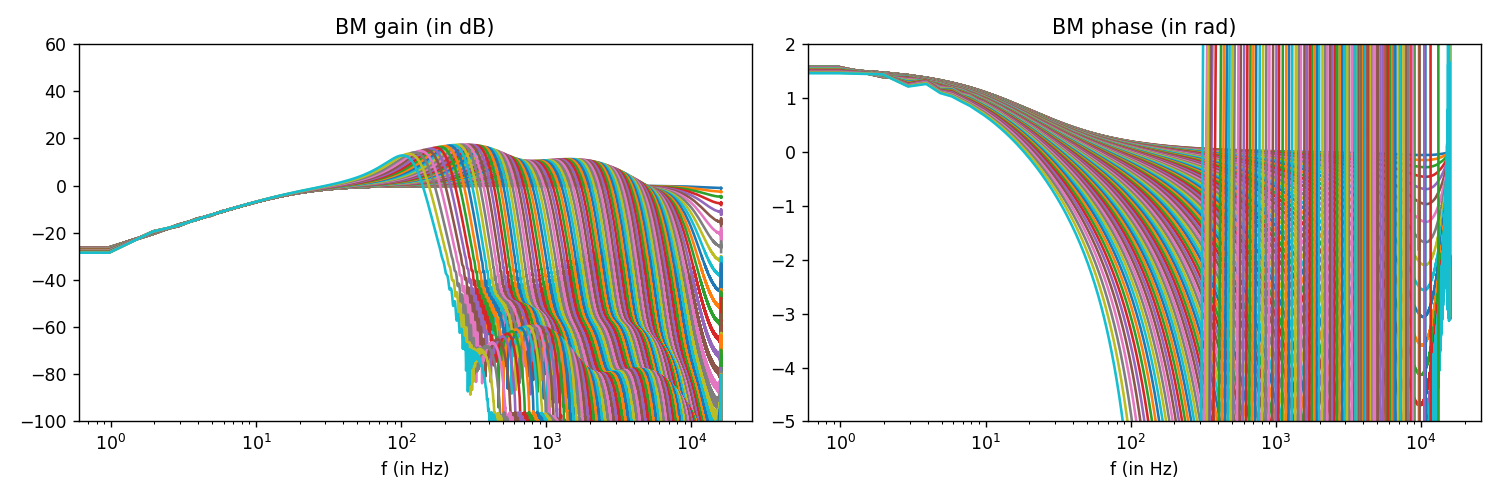

<IPython.core.display.Javascript object>


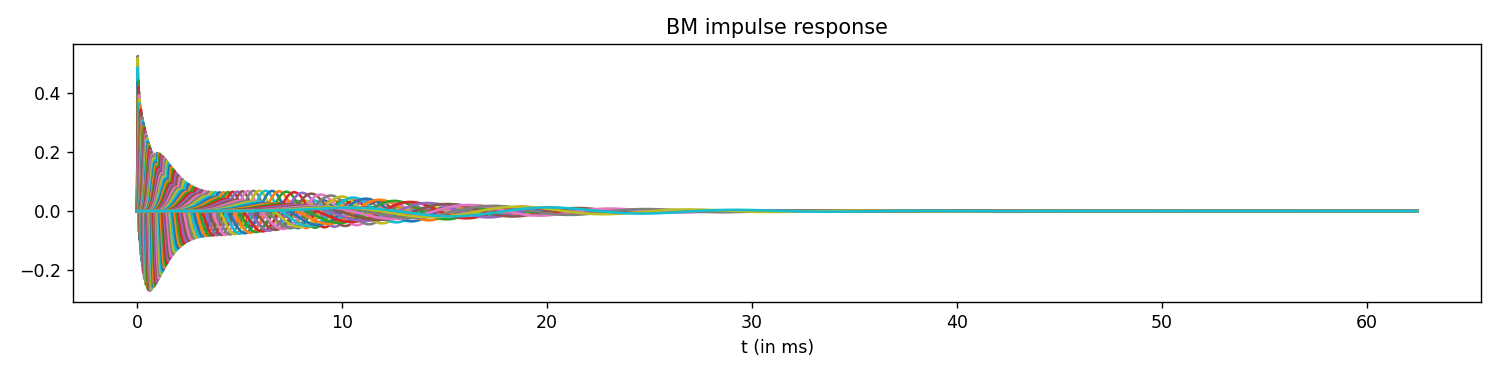

<IPython.core.display.Javascript object>


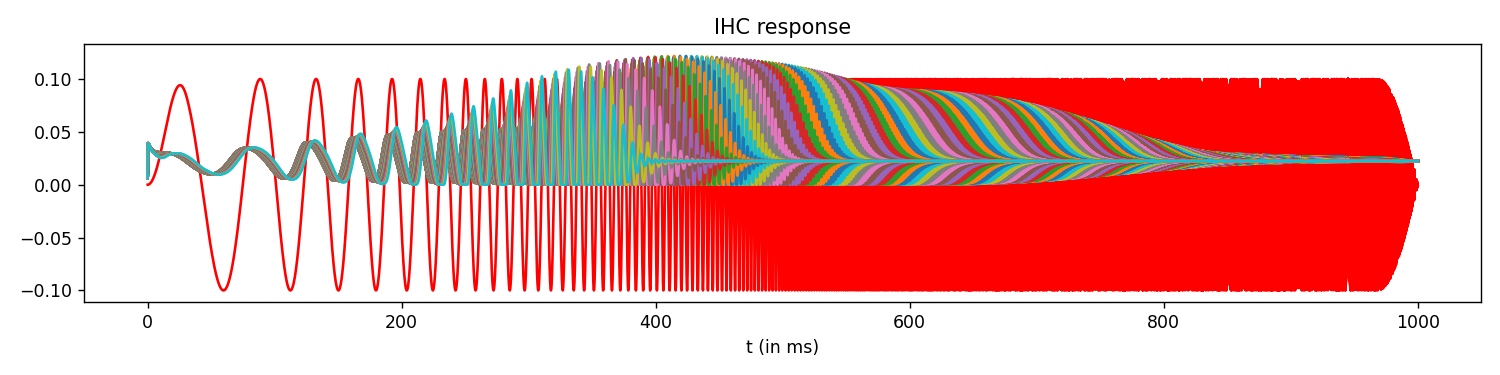

In [2]:
# plot the data

figure(1, figsize=(12,4)) # Bode plot of BM displacement 
ax1 = subplot(1,2,1)
freq = linspace(0,fs/2,(2**FL)/2)
semilogx(freq,20*log10(abs(myFFT.T[0:int((2**FL)/2),:])+1e-10))
title('BM gain (in dB)')
ylim([-100,60])
xlabel('f (in Hz)')
ax2 = subplot(1,2,2,sharex=ax1)
semilogx(freq,unwrap(angle(myFFT.T[0:int((2**FL)/2),:]),discont=5,axis=0))
title('BM phase (in rad)')
ylim([-5,2])
xlabel('f (in Hz)')
tight_layout()

figure(2, figsize=(12,3)) # BM impulse response
L=2000
plot(arange(L)*1000/fs,IR[:,0:L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

figure(3, figsize=(12,3)) # IHC output
plot(t1*1000,stimulus,'r')
plot(t1*1000,IHC.T)
xlabel('t (in ms)')
title('IHC response')
tight_layout()


For synthesizing the original input using the output of the BM model we need to find the synthesis filterbank transfer function which is the inverse of analysis filterbank of BM transfer function. The original input can be found by adding the output of all channels of synthesis filter bank with each other.

- Added by: Hadi Jamshidi
- Date: 2021.09.30

<IPython.core.display.Javascript object>


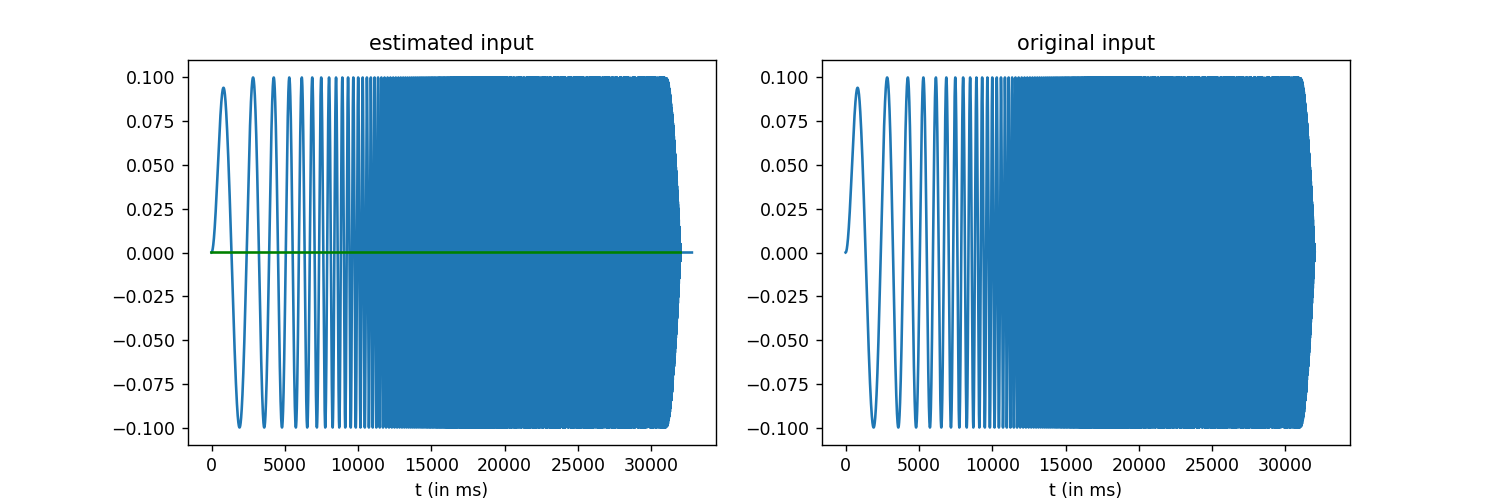

Text(0.5, 1.0, 'original input')

In [3]:
frequency_domain_input = fft(zeros(int(2**FL)))                              #Initializing frequancy-domain input array

synt_FB = 1/myFFT                                                            #Synthesis filterbak

for s in range(nsec):                                                        #Summing up the output of
     frequency_domain_input += 1/nsec*(fft(output[s],int(2**FL))*synt_FB[s]) #all the synthesis filterbank channels


time_domain_input = real(ifft(frequency_domain_input,int(2**FL)))            #Time-domain original input estimation

figure(4, figsize=(12,4))                                                    #Plot the estimated input in comparision
                                                                             #with the original input signal
estimated_input = subplot(1,2,1)
plot(time_domain_input)
plot(stimulus - time_domain_input[0:npoints],'g')                      #difference between original and estimated signals (in samples)
xlabel('t (in ms)')
title('estimated input')


orignal_input = subplot(1,2,2,sharex=estimated_input)
plot(stimulus)
xlabel('t (in ms)')
title('original input')

Next we plot the output of the AGC loop versus section number and time. The top figure shows the 3d version of this, and the bottom figure the cross sections. You can see that the output becomes stable after 0.4s of the presentation of the pure tone.

<IPython.core.display.Javascript object>


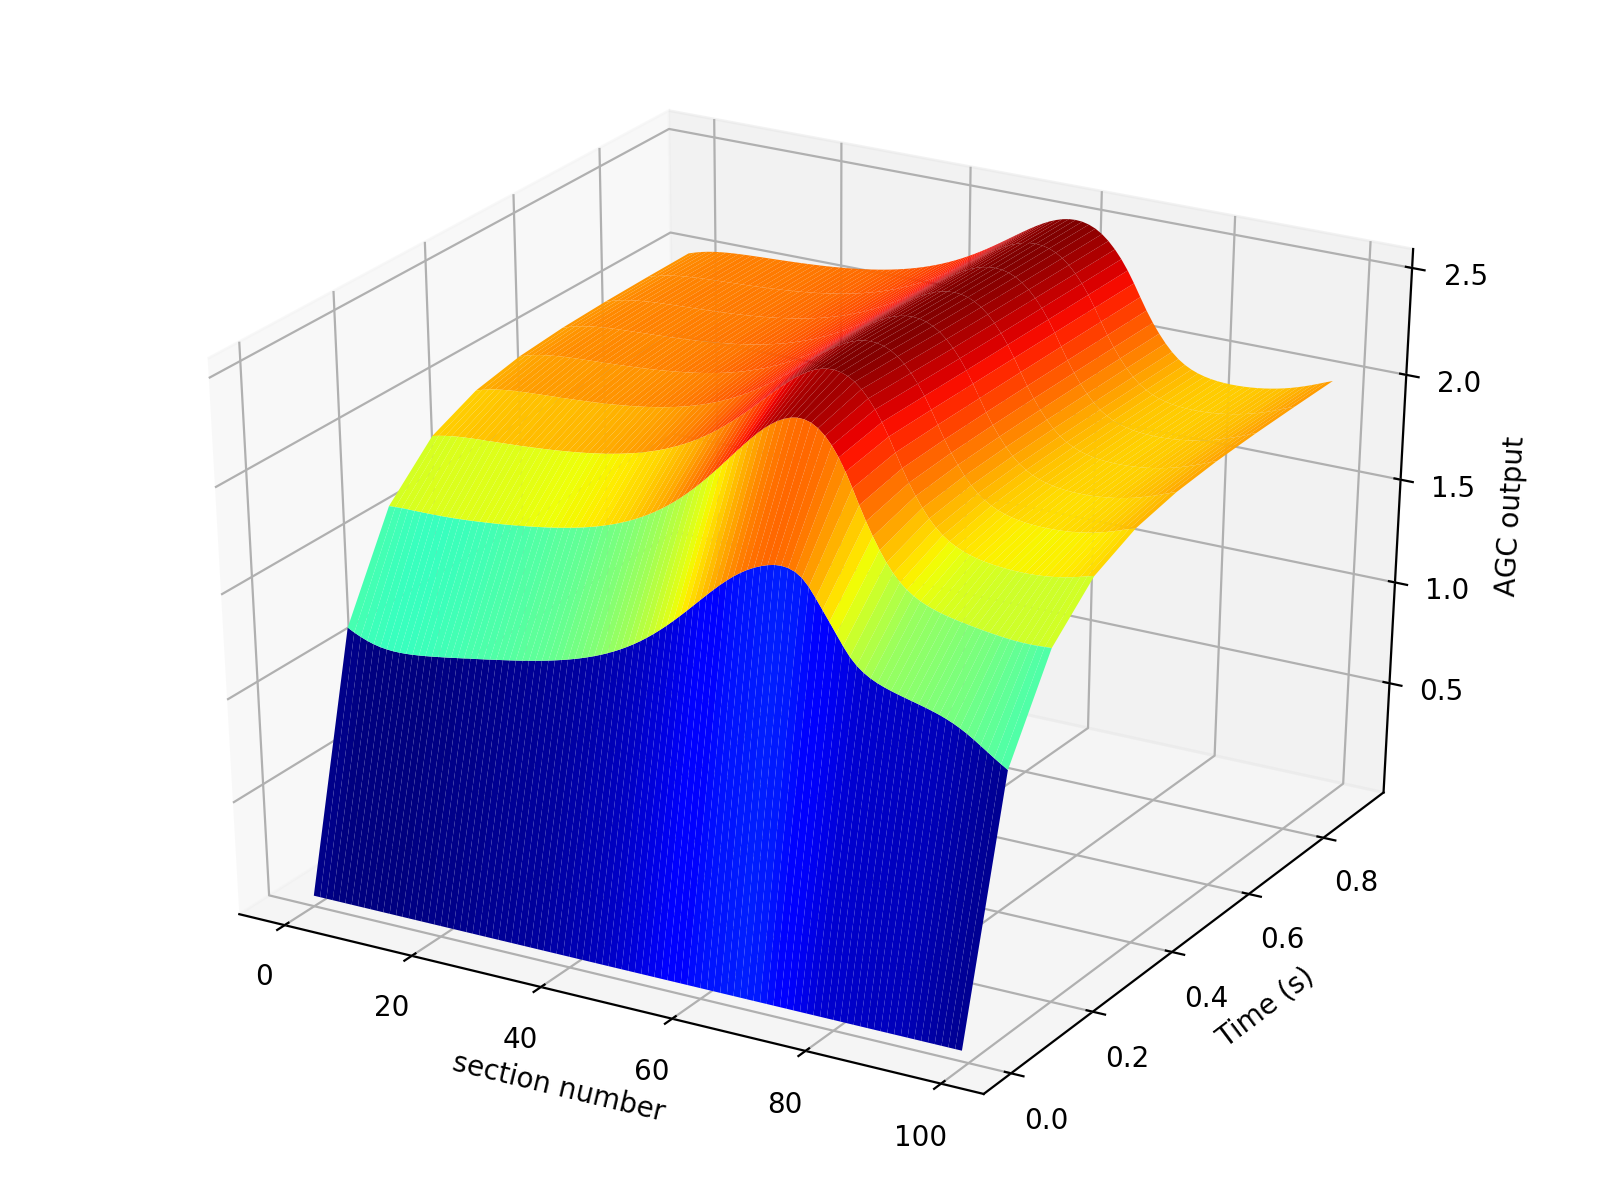

<IPython.core.display.Javascript object>


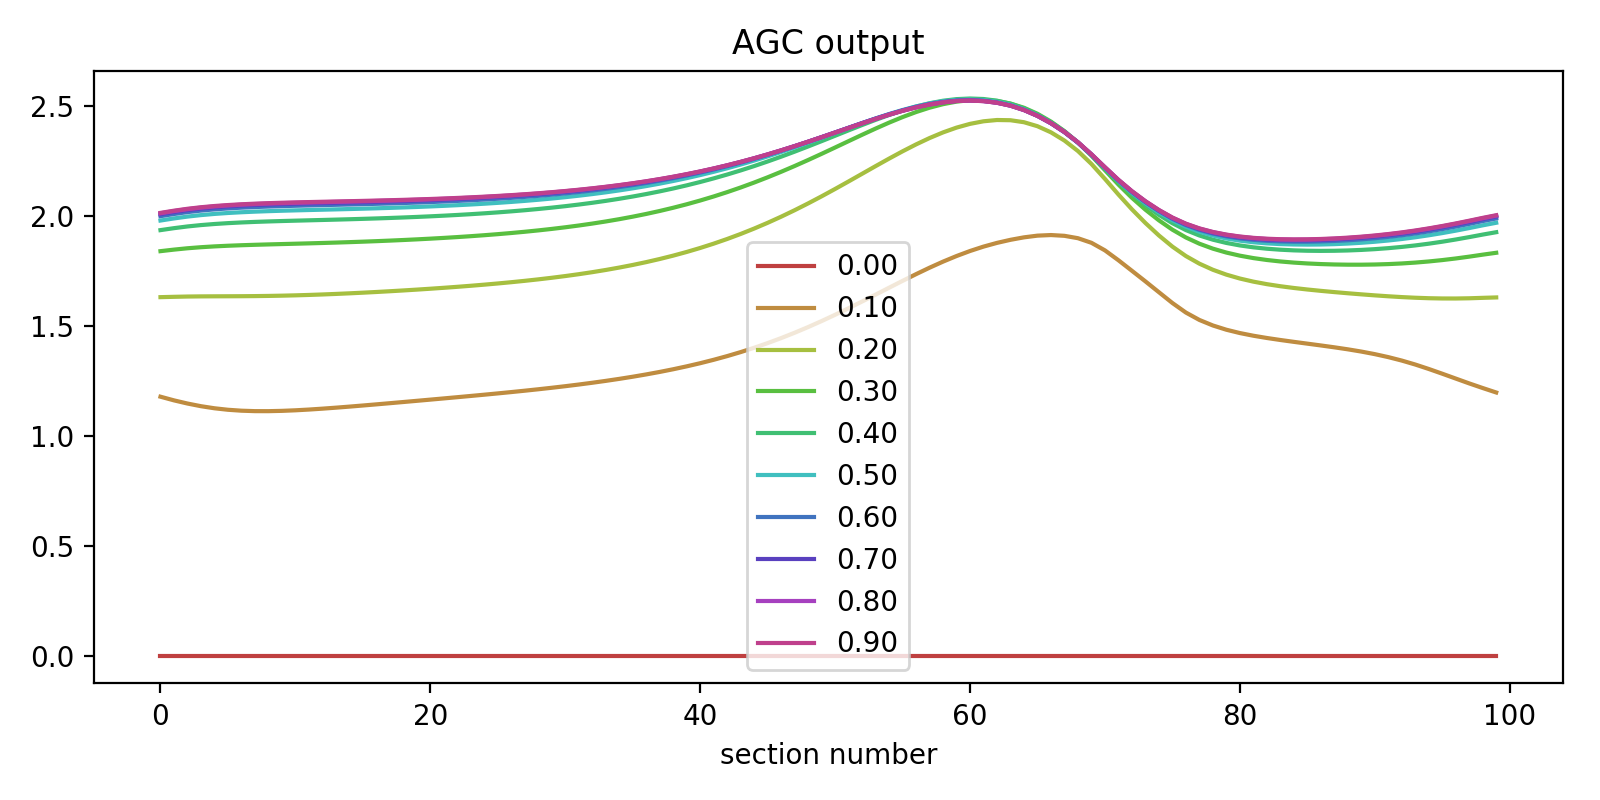

(100, 32000)


In [3]:
fig = figure(4, figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
t = linspace(0,1,10,False)*dur
X,Y = meshgrid(linspace(0,nsec,nsec,False),t)
ax.plot_surface(X,Y,AGC[:,(t*fs).astype(int)].T, rstride=1, cstride=1, cmap=cm.jet, linewidth=0)
ax.set_xlabel("section number")
ax.set_ylabel("Time (s)")
ax.set_zlabel("AGC output")
tight_layout()

figure(5, figsize=(8,4))
for t in range(10):
    plot(AGC[:,t*npoints/10], label="%0.2f" % (t*npoints/10/fs), color=colorsys.hls_to_rgb(t/10.0, .5, .5))
legend()
title ('AGC output')
xlabel('section number')
tight_layout()
print AGC.shape

Finally, we plot the distribution of b across the sections at the end of the pure tone stimulation:

<IPython.core.display.Javascript object>


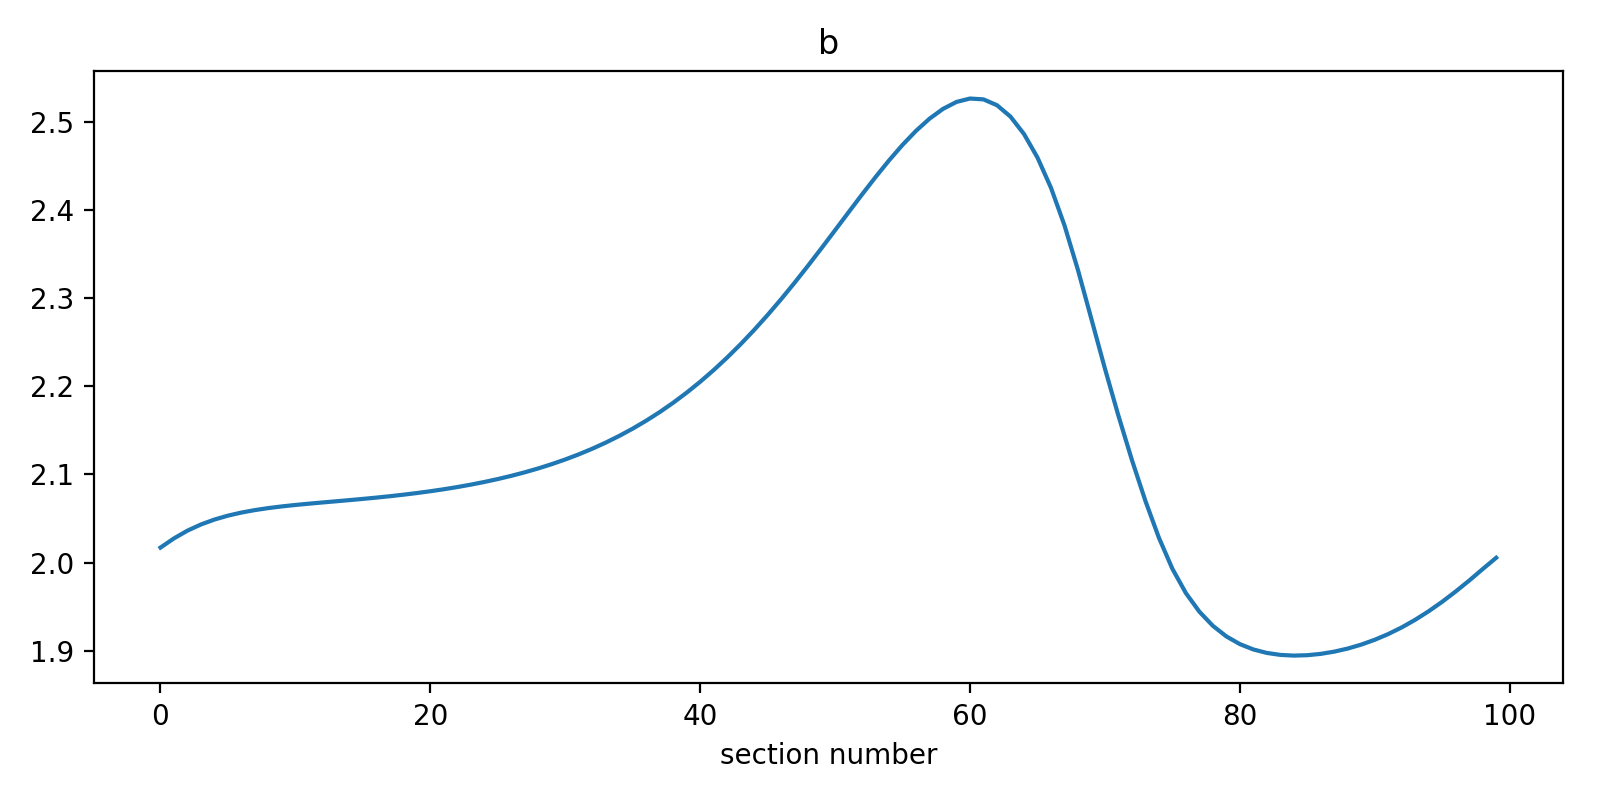

In [4]:
figure(6, figsize=(8,4))
plot(b)
title('b')
xlabel('section number')
tight_layout()